In [1]:
import psycopg2 as ps
import pandas as pd
import numpy as np

import requests
import json
import io

from pylab import rcParams
rcParams['figure.figsize'] = 8, 5

from sklearn.metrics import ndcg_score, accuracy_score
import random

import chgk_api as cha

# настройки pandas, с которыми лучше почти всегда
pd.set_option('display.max_rows', 45000)
pd.set_option('display.max_columns', 50000)
pd.set_option('display.max_colwidth', 5000)

In [2]:
# настройки
# количество вопросов "виртуальной перестрелки", кототорое планируем моделировать
test_distnce = 8

# процентили, на которые мы разделили выборрку турнира по стартовому рейтингу
first_percentile = 0.1
second_percentile = 0.5

# количество команд, которые участвуют в построении метрики
k_opt = 200

# тестовый период для проверки работы функций
test_start_date = '2024-12-01'
test_finish_date = '2024-12-02'

# продовое время для обработки биг даты
start_date = '2023-01-01'
finish_date = '2025-12-01'

In [3]:
def make_metrics(df, segment_col, target_col, pred_col, k=5, is_size=True, suffix='', param_value='', param_col='', tourn_id=0):
    """
    Функция для точности прогноза. 
    Сейчас это ndcg_score https://scikit-learn.org/dev/modules/generated/sklearn.metrics.ndcg_score.html
    """
    work_df = df.copy()
    work_df.sort_values(by=[target_col, segment_col], ascending=[True, True])
    grouped = work_df.groupby(segment_col)
    ndcg_lst = []
    acc_lst = []

    for name, group in grouped:
        group = group.sort_values(by=target_col)
        y_true = np.array([group[target_col]])
        y_pred = np.array([group[pred_col]])
        
        ndcg = ndcg_score(y_true, y_pred, k=k)
        ndcg_lst.append({segment_col: name, 'ndcg': ndcg})

        # accuracy_score не работает с float, 
        # поэтому выводим дробную часть в виде числа
        # y_true = (y_true * 10).astype('int')
        # y_pred = (y_pred * 10).astype('int')
        # поэтому округляем вниз, делённое место считаем целевым
        y_true = np.floor(y_true).astype('int')
        y_pred = np.floor(y_pred).astype('int')

        acc = accuracy_score(y_true[0], y_pred[0])
        acc_lst.append({segment_col: name, 'accuracy': acc})

    metrics_df = work_df.groupby(segment_col).agg(
                                                    size = ('team_id', 'nunique'),
                                                    ).reset_index()
    ndcg_df = pd.DataFrame(ndcg_lst)
    acc_df = pd.DataFrame(acc_lst)

    metrics_df = metrics_df.merge(ndcg_df, 'left', on=segment_col)
    metrics_df = metrics_df.merge(acc_df, 'left', on=segment_col)

    if is_size == False:
        del metrics_df['size']
        metrics_df.columns = ['segment', 'ndcg'+suffix, 'accuracy'+suffix]
    else:
        metrics_df.columns = ['segment', 'size', 'ndcg'+suffix, 'accuracy'+suffix]
    
    metrics_df['tourn_id'] = tourn_id
    metrics_df[param_col] = param_value

    return metrics_df

def get_target(df):
    """
    Функция для расчёта целевой метрики
    Сейчас - это ранг суммы взятых с усреднением
    """
    totals_df = df.groupby(['tourn_id', 'team_id']).agg(
        target_question = ('qv_result', 'sum'),
    ).reset_index()
    totals_df['target'] = totals_df.groupby(['tourn_id'])['target_question'].rank(method='average', ascending=False)

    return totals_df

def get_current_taken_forecast(df, qv_num, segment_col):
    """
    Функция для расчёта прогноза "по взятым".
    В конце турнира команда займёт такое место, какое занимает на этап после qv_num вопроса
    """
    gr_df = df[df['question_num'] <= qv_num].groupby(['tourn_id', 'team_id', segment_col]).agg(
        current_res = ('qv_result', 'sum'),
    ).reset_index()

    totals_df = get_target(df)
    gr_df = gr_df.merge(totals_df, 'left', on=['tourn_id', 'team_id'])
    gr_df['current_place'] = gr_df.groupby(['tourn_id'])['current_res'].rank(method='average', ascending=False)
    gr_df = gr_df.sort_values(by='target_question', ascending=False)

    return gr_df

def get_current_qv_rating_forecast(df, qv_num, segment_col):
    """
    Функция для расчёта прогноза "по рейтингу взятых вопросов".
    В конце турнира команда займёт такое место, какое занимает на этап после qv_num по рейтингу взятых
    """
    # статистика по вопросам
    qv_stat_df = df.groupby(['tourn_id', 'question_num']).agg(
        taked = ('qv_result', 'sum'),
        total = ('qv_result', 'count'),
    ).reset_index()
    # рейтинг вопроса - количество команд, которые его не взяли
    qv_stat_df['qv_rating'] = qv_stat_df['total'] - qv_stat_df['taked']

    qv_df = df.merge(qv_stat_df, 'left', on=['tourn_id', 'question_num'])
    # вопросный рейтинг команды - суммарный рейтинг вопросов, которые она взяла  
    qv_df['rating'] = qv_df['qv_rating'] * qv_df['qv_result'] 

    gr_df = qv_df[qv_df['question_num'] <= qv_num].groupby(['tourn_id', 'team_id', segment_col]).agg(
        current_rating = ('rating', 'sum'),
    ).reset_index()
    gr_df['rating_place'] = gr_df.groupby(['tourn_id'])['current_rating'].rank(method='average', ascending=False)

    totals_df = get_target(df)

    gr_df = gr_df.merge(totals_df, 'left', on=['tourn_id', 'team_id'])

    return gr_df


def get_tours_distr(json_data):
    """
    Собираем структуру турнира по json из API
    """
    size = len(json_data)
    qv_lst = []
    tour_lst = []
    max_qv = 0
    for t in range(1, size+1):
        rr = range(max_qv+1, max_qv+json_data[str(t)]+1)
        max_qv = rr[-1]
        for q in rr:
            qv_lst.append(q)
            tour_lst.append(t)
    
    df = pd.DataFrame(qv_lst, columns=['question_num'])
    df['tour_id'] = tour_lst
    return df


def get_tours_res_forecast(df, qv_num, segment_col):
    """
    Функция для расчёта прогноза по сумме мест в турах
    """
    tours_distr = get_tours_distr(df['questionQty'].values[0])
    df = df.merge(tours_distr, 'left', on='question_num')

    gr_df = df[df['question_num'] <= qv_num].groupby(['tourn_id', 'team_id', 'tour_id', segment_col]).agg(
        current_res = ('qv_result', 'sum'),
    ).reset_index()

    gr_df['tour_place'] = gr_df.groupby(['tourn_id', 'tour_id'])['current_res'].rank(method='average', ascending=False)
    
    tr_df = gr_df.groupby(['tourn_id', 'team_id', segment_col]).agg(
        tour_placses = ('tour_place', 'sum'),
    ).reset_index()
    tr_df['tour_forecast'] = tr_df.groupby(['tourn_id'])['tour_placses'].rank(method='average', ascending=True)

    totals_df = get_target(df)
    tr_df = tr_df.merge(totals_df, 'left', on=['tourn_id', 'team_id'])
    tr_df = tr_df.sort_values(by='target_question', ascending=False)

    return tr_df

def get_data(tourn_id):
    """
    Функция для сборки датасета и проставлении необхоимых полей
    """
    # получаем данные по API
    tourn_df, question_df, players_df = cha.get_tourn_result(tourn_id)
    qv_stat = cha.tourn_stat(question_df)

    # назначаем командам сегмент по стартовой крутости
    tourn_df['segment'] =np.where(
        (tourn_df['predictedPosition'] <= tourn_df['predictedPosition'].quantile(.1)), '1.top_10%',
        np.where(
                    (tourn_df['predictedPosition'] <= tourn_df['predictedPosition'].quantile(.5)) &
                    (tourn_df['predictedPosition'] > tourn_df['predictedPosition'].quantile(.1)), '2.top_50%', '3.bottom_50%'
                )
                                )
    

    # собираем нужный датасет
    work_df = qv_stat.merge(tourn_df[['tourn_id', 'team_id', 'predictedPosition', 'position', 'segment']], 'left', on=['tourn_id', 'team_id'])
    work_df['qv_result'] = work_df['qv_result'].astype('int')

    work_df = work_df.sort_values(by=['tourn_id', 'predictedPosition', 'segment', 'team_id', 'question_num'])

    return tourn_df, question_df, players_df, work_df

def get_tourn_stat(work_df):
    """
    Функция которая для каждого вопроса турнира считает по двум метрикам (точность и ndcg) следующие прогнозы
    - случайная тасовка команд
    - прогноз по стартовому рейтингу
    - прогноз по текущему месту
    - прогноз по текущему рейтингу
    - прогноз по сумме мест в туре
    """
    # собранный датассет по одному турниру
    tourn_id = work_df['tourn_id'].values[0]

    num_of_questions = work_df['numqv'].values[0]
    num_of_teams = work_df['team_id'].nunique()

    questions = pd.DataFrame(range(1, num_of_questions+1), columns=['question_num'])
    questions['tourn_id'] = tourn_id

    # прогноз по стартовому рейтингу
    teams_smpl = work_df[['tourn_id', 'team_id', 'position', 'predictedPosition', 'segment']].drop_duplicates()
    start_df_forec = make_metrics(
                    teams_smpl, 
                    segment_col='segment', 
                    target_col='position', 
                    pred_col='predictedPosition', 
                    is_size=True, 
                    k=k_opt,
                    suffix='_start_rating_forecast', 
                    tourn_id=tourn_id)

    res_df = questions.merge(start_df_forec, 'left', on='tourn_id')

    # прогноз по случайной тасовке команд
    places= list(range(1, len(teams_smpl)+1))
    random.shuffle(places)
    teams_smpl['random'] = places
    shuffle_forecast = make_metrics(
                    teams_smpl, 
                    segment_col='segment', 
                    target_col='position', 
                    pred_col='random', 
                    is_size=False, 
                    k=k_opt,
                    suffix='_shuffle_forecast', 
                    tourn_id=tourn_id)


    res_df = res_df.merge(shuffle_forecast, 'left', on=['segment'], suffixes=('', '_random'))

    qv_forecast_metric_df = pd.DataFrame()
    rating_forecast_metric_df = pd.DataFrame()
    tours_sum_forecast_metric_df = pd.DataFrame()
    for i in range(1, num_of_questions+1):
        qv_forecast_df = get_current_taken_forecast(work_df, i, 'segment')
        rating_forecast_df = get_current_qv_rating_forecast(work_df, i, 'segment')
        tours_sum_forecast_df = get_tours_res_forecast(work_df, i, 'segment')

        qv_forecast_metric_df_b = make_metrics(
                        qv_forecast_df, 
                        segment_col='segment', 
                        target_col='target', 
                        pred_col='current_place', 
                        is_size=False, 
                        k=k_opt,
                        suffix='_current_place_forecast', 
                        param_value=i,
                        param_col='question_num', 
                        tourn_id=tourn_id)
        
        rating_forecast_metric_df_b = make_metrics(
                        rating_forecast_df, 
                        segment_col='segment', 
                        target_col='target', 
                        pred_col='rating_place', 
                        is_size=False, 
                        k=k_opt,
                        suffix='_qv_rating_place_forecast', 
                        param_value=i,
                        param_col='question_num', 
                        tourn_id=tourn_id)
        
        tours_sum_forecast_metric_df_b = make_metrics(
                        tours_sum_forecast_df, 
                        segment_col='segment', 
                        target_col='target', 
                        pred_col='tour_forecast', 
                        is_size=False, 
                        k=k_opt,
                        suffix='_tours_sum_forecast', 
                        param_value=i,
                        param_col='question_num', 
                        tourn_id=tourn_id)

        qv_forecast_metric_df = pd.concat([qv_forecast_metric_df, qv_forecast_metric_df_b])
        rating_forecast_metric_df = pd.concat([rating_forecast_metric_df, rating_forecast_metric_df_b])
        tours_sum_forecast_metric_df = pd.concat([tours_sum_forecast_metric_df, tours_sum_forecast_metric_df_b])

    res_df = res_df.merge(qv_forecast_metric_df, 'left', on=['tourn_id', 'segment', 'question_num'])
    res_df = res_df.merge(rating_forecast_metric_df, 'left', on=['tourn_id', 'segment', 'question_num'])
    res_df = res_df.merge(tours_sum_forecast_metric_df, 'left', on=['tourn_id', 'segment', 'question_num'])

    # в качестве прогноза берём ситуацию перед начало "виртуальной перестрелки"
    forec_df = res_df[res_df['question_num'] == num_of_questions - test_distnce]

    return res_df, forec_df

In [4]:
# проверяем работу функций
# список турниров за определённую дату, первая страница пагинации
tourn_lst_df = cha.get_tourn_list(test_start_date, test_finish_date, 1)
tourn_lst_df.sample(3)

Status code:  200


,tourn_id,tourn_name,type,season,difficulty_forecast,is_rating,trueDL,questionQty
0,11350,НижВышФест-2024,Обычный,59,4.5,True,4.44091,"{'1': 13, '2': 13, '3': 13, '4': 13}"
1,11416,"Фестиваль интеллектуальных игр ""Memory Fest""",Обычный,59,0.0,True,3.69327,"{'1': 12, '2': 12, '3': 12, '4': 12}"
2,11448,"Фестиваль интеллектуальных игр ""Memory Fest. SPB""",Обычный,59,0.0,True,3.69791,"{'1': 12, '2': 12, '3': 12, '4': 12}"


In [5]:
# собранный датассет по одному турниру
tourn_id = tourn_lst_df['tourn_id'].values[0]
tourn_df, question_df, players_df, work_df = get_data(tourn_id)
work_df = work_df.merge(tourn_lst_df, on='tourn_id')
work_df.sample(3)

Status code:  200


,tourn_id,team_id,numqv,question_num,qv_result,predictedPosition,position,segment,tourn_name,type,season,difficulty_forecast,is_rating,trueDL,questionQty
578,11350,93765,52,7,0,12,13.0,2.top_50%,НижВышФест-2024,Обычный,59,4.5,True,4.44091,"{'1': 13, '2': 13, '3': 13, '4': 13}"
221,11350,92787,52,14,1,5,5.5,2.top_50%,НижВышФест-2024,Обычный,59,4.5,True,4.44091,"{'1': 13, '2': 13, '3': 13, '4': 13}"
1447,11350,100070,52,44,0,28,27.5,3.bottom_50%,НижВышФест-2024,Обычный,59,4.5,True,4.44091,"{'1': 13, '2': 13, '3': 13, '4': 13}"


In [6]:
# прогноз по занятому месту к 12 вопросу по сегменту стартовой крутости
grtf = get_current_taken_forecast(work_df, 12, 'segment')
grtf.sample(3)

,tourn_id,team_id,segment,current_res,target_question,target,current_place
14,11350,89357,3.bottom_50%,6,19,21.5,18.5
11,11350,88127,1.top_10%,9,32,4.0,4.0
24,11350,100049,3.bottom_50%,6,15,23.5,18.5


In [7]:
# метрики точности прогноза по сегментам
make_metrics(
                grtf, 
                segment_col='segment', 
                target_col='target', 
                pred_col='current_place', 
                is_size=True, 
                k=k_opt,
                suffix='_current_taken', 
                tourn_id=tourn_id)

,segment,size,ndcg_current_taken,accuracy_current_taken,tourn_id,
0,1.top_10%,4,0.896666,0.5,11350,
1,2.top_50%,12,0.955135,0.0,11350,
2,3.bottom_50%,15,0.951863,0.0,11350,


In [8]:
# по всей выборке тоже можно сделать
make_metrics(
                grtf, 
                segment_col='tourn_id', 
                target_col='target', 
                pred_col='current_place', 
                is_size=True, 
                suffix='_current_taken', 
                tourn_id=tourn_id)

,segment,size,ndcg_current_taken,accuracy_current_taken,tourn_id,
0,11350,31,0.870292,0.064516,11350,


In [9]:
# прогноз по рейтингу взятых вопросов к 12 вопросу по сегменту стартовой крутости
gcqrf = get_current_qv_rating_forecast(work_df, 12, 'segment')
gcqrf.sample(3)

,tourn_id,team_id,segment,current_rating,rating_place,target_question,target
20,11350,98910,3.bottom_50%,20,27.0,8,31.0
10,11350,87772,2.top_50%,65,15.0,30,8.0
0,11350,68620,3.bottom_50%,36,24.0,14,25.5


In [10]:
# метрики точности прогноза по сегментам
make_metrics(
                gcqrf, 
                segment_col='segment', 
                target_col='target', 
                pred_col='rating_place', 
                is_size=True, 
                suffix='_qv_rating_forecast', 
                tourn_id=tourn_id)

,segment,size,ndcg_qv_rating_forecast,accuracy_qv_rating_forecast,tourn_id,
0,1.top_10%,4,0.896666,0.0,11350,
1,2.top_50%,12,0.831750,0.0,11350,
2,3.bottom_50%,15,0.848887,0.0,11350,


In [11]:
# прогноз по сумме мест в турах к 12 вопросу по сегменту стартовой крутости
gtrf = get_tours_res_forecast(work_df, 12, 'segment')
gtrf.sample(3)

,tourn_id,team_id,segment,tour_placses,tour_forecast,target_question,target
0,11350,68620,3.bottom_50%,26.0,26.0,14,25.5
4,11350,79496,2.top_50%,12.5,12.5,31,5.5
27,11350,100161,3.bottom_50%,18.5,18.5,26,13.0


In [12]:
# метрики точности прогноза по сегментам
make_metrics(
                gtrf, 
                segment_col='segment', 
                target_col='target', 
                pred_col='tour_forecast', 
                is_size=True, 
                suffix='_tours_forecast', 
                tourn_id=tourn_id)

,segment,size,ndcg_tours_forecast,accuracy_tours_forecast,tourn_id,
0,1.top_10%,4,0.896666,0.5,11350,
1,2.top_50%,12,0.868480,0.0,11350,
2,3.bottom_50%,15,0.867450,0.0,11350,


In [13]:
# прогноз по стартовому рейтингу
trdf = work_df[['tourn_id', 'team_id', 'position', 'predictedPosition', 'segment']].drop_duplicates()
make_metrics(
                trdf, 
                segment_col='segment', 
                target_col='position', 
                pred_col='predictedPosition', 
                is_size=True, 
                suffix='_start_rating', 
                tourn_id=tourn_id)

,segment,size,ndcg_start_rating,accuracy_start_rating,tourn_id,
0,1.top_10%,4,0.863453,0.500000,11350,
1,2.top_50%,12,0.903280,0.416667,11350,
2,3.bottom_50%,15,0.940157,0.066667,11350,


In [14]:
# прогноз по случайной тасовке команд
places = list(range(1, len(trdf)+1))
random.shuffle(places)
trdf['random'] = places
make_metrics(
                trdf, 
                segment_col='segment', 
                target_col='position', 
                pred_col='random', 
                is_size=True, 
                suffix='_random', 
                tourn_id=tourn_id)

,segment,size,ndcg_random,accuracy_random,tourn_id,
0,1.top_10%,4,0.758369,0.000000,11350,
1,2.top_50%,12,0.521535,0.000000,11350,
2,3.bottom_50%,15,0.833170,0.066667,11350,


In [15]:
# можно получить метрику "хуже рандома": если отсортировать в противоположную сторону
trdf['worst'] = trdf.groupby(['tourn_id'])['position'].rank(method='average', ascending=False)
make_metrics(
                trdf, 
                segment_col='segment', 
                target_col='position', 
                pred_col='worst', 
                is_size=True, 
                suffix='_revers', 
                tourn_id=tourn_id)

,segment,size,ndcg_revers,accuracy_revers,tourn_id,
0,1.top_10%,4,0.748903,0.0,11350,
1,2.top_50%,12,0.329088,0.0,11350,
2,3.bottom_50%,15,0.490330,0.0,11350,


In [16]:
# а теперь проход по всем вопроса турнира
res_df, forec_df = get_tourn_stat(work_df)
res_df.sample(3)

,question_num,tourn_id,segment,size,ndcg_start_rating_forecast,accuracy_start_rating_forecast,,ndcg_shuffle_forecast,accuracy_shuffle_forecast,tourn_id_random,_random,ndcg_current_place_forecast,accuracy_current_place_forecast,ndcg_qv_rating_place_forecast,accuracy_qv_rating_place_forecast,ndcg_tours_sum_forecast,accuracy_tours_sum_forecast
69,24,11350,1.top_10%,4,0.863453,0.500000,,0.885450,0.0,11350,,0.896666,0.25,0.896666,0.25,0.896666,0.25
13,5,11350,2.top_50%,12,0.965496,0.416667,,0.802292,0.0,11350,,0.896329,0.00,0.938817,0.00,0.896329,0.00
90,31,11350,1.top_10%,4,0.863453,0.500000,,0.885450,0.0,11350,,0.896666,0.25,0.896666,0.25,0.896666,0.25


In [17]:
len(res_df)

156

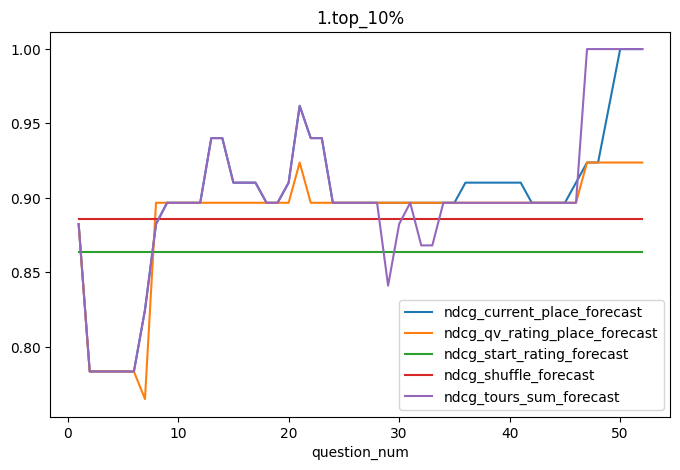

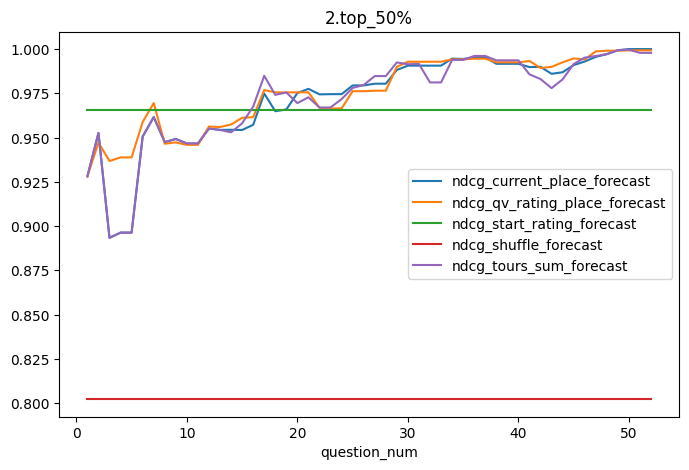

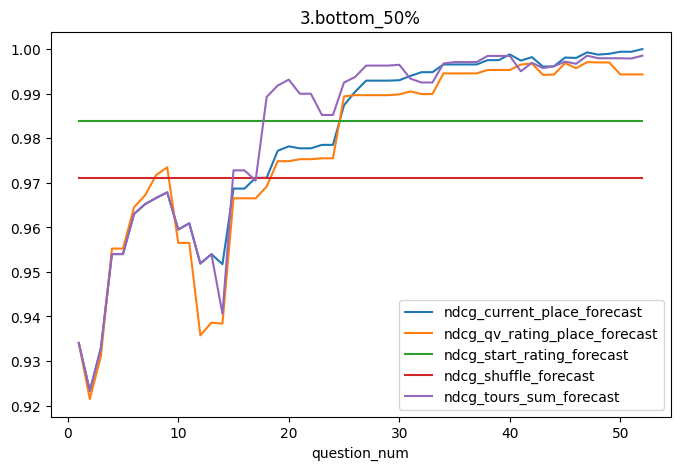

In [18]:
for segment in res_df['segment'].unique():
    res_df[res_df['segment'] == segment].set_index('question_num')[[
                                                                    'ndcg_current_place_forecast', 
                                                                    'ndcg_qv_rating_place_forecast',
                                                                    'ndcg_start_rating_forecast', 
                                                                    'ndcg_shuffle_forecast', 
                                                                    'ndcg_tours_sum_forecast'
                                                                    ]].plot(title=segment)

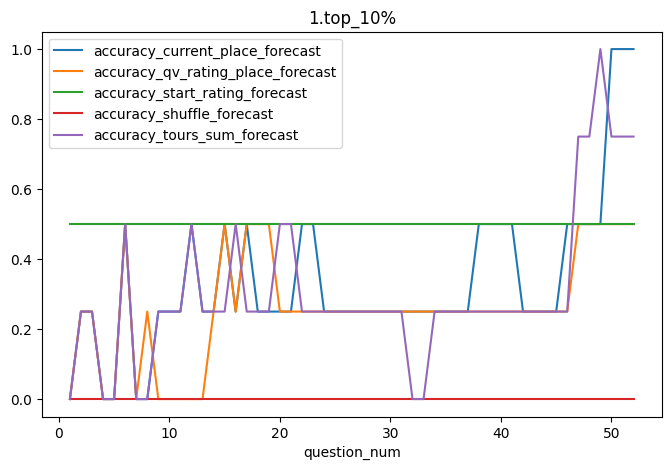

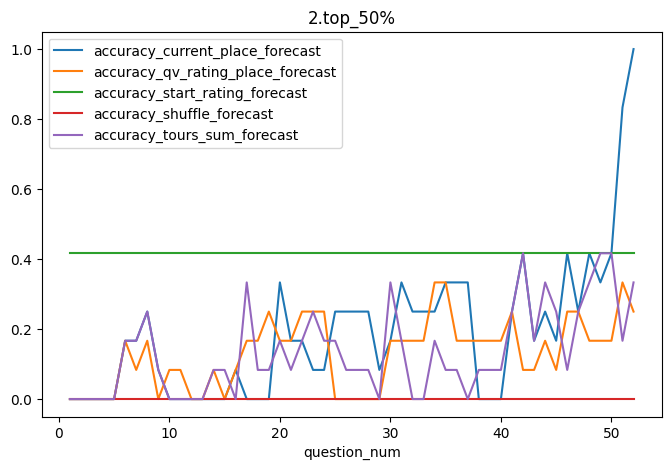

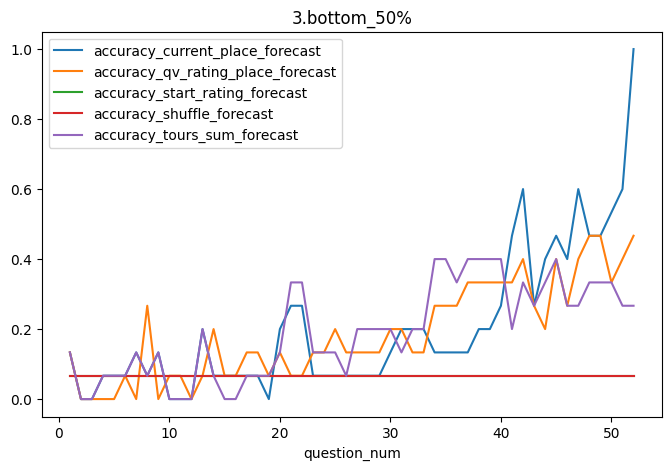

In [19]:
for segment in res_df['segment'].unique():
    res_df[res_df['segment'] == segment].set_index('question_num')[[
                                                                    'accuracy_current_place_forecast', 
                                                                    'accuracy_qv_rating_place_forecast',
                                                                    'accuracy_start_rating_forecast', 
                                                                    'accuracy_shuffle_forecast', 
                                                                    'accuracy_tours_sum_forecast'
                                                                    ]].plot(title=segment)

In [20]:
forec_df.set_index('segment')[[                                                                    'ndcg_current_place_forecast', 
                                                                        'ndcg_qv_rating_place_forecast',
                                                                        'ndcg_start_rating_forecast', 
                                                                        'ndcg_shuffle_forecast', 'ndcg_tours_sum_forecast']].T

segment,1.top_10%,2.top_50%,3.bottom_50%
ndcg_current_place_forecast,0.896666,0.986925,0.996139
ndcg_qv_rating_place_forecast,0.896666,0.992502,0.994283
ndcg_start_rating_forecast,0.863453,0.965496,0.983800
ndcg_shuffle_forecast,0.885450,0.802292,0.971104
ndcg_tours_sum_forecast,0.896666,0.982896,0.996131


In [21]:
# # выводим показатели топ-20 по турниру по разным метрикам
# в целом, это отладка
# tourn_df = tourn_df.merge(qv_forecast_df, 'left', on=['tourn_id', 'team_id'], suffixes=('', '_1'))
# tourn_df = tourn_df.merge(rating_forecast_df, 'left', on=['tourn_id', 'team_id'], suffixes=('', '_2'))
# tourn_df = tourn_df.merge(tours_sum_forecast_df, 'left', on=['tourn_id', 'team_id'], suffixes=('', '_3'))
# tourn_df[[
#     'tourn_id',
#     'team_id', 'team_name',
#     'position', 'result',
#     'segment',
#     'current_place', 'rating_place', 'tour_forecast'
# ]][0:20]

In [22]:
# TO DO
# комментарии
# признак равенства очков на момент перестрелки
# обратная перестрелка (без микроматчей никак)
# приджойнить метрики к ворку
# +добавить две метода к общему резу
# +приджойнить параметры турниров к турниру
# стату по набору турниров

In [23]:
# полный список турниров за период
# там ещё уникальные параметры турниров переджаются (которые по апи самого турнира не достать)
tourn_lst_df = pd.DataFrame()
# апи на машстабах от полугода до года где-то падает
# нарежем по месяцам, чтобы наверняка 
periods = pd.date_range(start=start_date, end=finish_date, freq='ME')

for i in range(len(periods)-1):
    print(periods[i])
    # а ещё тут есть пагинация
    # и ни одного штатного способа узнать количество страниц я не вижу, поэтому ставим "с запасом"
    for page in range(1, 100):
        print(page)
        # тут бы два обработчика: когда страницы кончились и на прочие ошибки
        try:
            tourn_lst_df_pag = cha.get_tourn_list(periods[i], periods[i+1], page)
            print("Число турниров в порции: ", len(tourn_lst_df_pag))
            tourn_lst_df = pd.concat([tourn_lst_df, tourn_lst_df_pag])
        except:
            break


print("Общее число турниров в наборе: ", len(tourn_lst_df))

2023-01-31 00:00:00
1
Status code:  200
Число турниров в порции:  45
2
Status code:  200
2023-02-28 00:00:00
1
Status code:  200
Число турниров в порции:  58
2
Status code:  200
2023-03-31 00:00:00
1
Status code:  200
Число турниров в порции:  71
2
Status code:  200
2023-04-30 00:00:00
1
Status code:  200
Число турниров в порции:  61
2
Status code:  200
2023-05-31 00:00:00
1
Status code:  200
Число турниров в порции:  49
2
Status code:  200
2023-06-30 00:00:00
1
Status code:  200
Число турниров в порции:  46
2
Status code:  200
2023-07-31 00:00:00
1
Status code:  200
Число турниров в порции:  30
2
Status code:  200
2023-08-31 00:00:00
1
Status code:  200
Число турниров в порции:  38
2
Status code:  200
2023-09-30 00:00:00
1
Status code:  200
Число турниров в порции:  57
2
Status code:  200
2023-10-31 00:00:00
1
Status code:  200
Число турниров в порции:  61
2
Status code:  200
2023-11-30 00:00:00
1
Status code:  200
Число турниров в порции:  76
2
Status code:  200
2023-12-31 00:00:00
1

In [24]:
tourn_lst_df.sample(3)

,tourn_id,tourn_name,type,season,difficulty_forecast,is_rating,trueDL,questionQty
32,11037,Дровушки. День 1,Синхрон,58,5.0,True,5.23170,"{'1': 12, '2': 12, '3': 12}"
40,11054,Полесские хроники. Орёл,Синхрон,58,4.5,True,4.54916,"{'1': 12, '2': 12, '3': 12}"
29,11026,Лига трёх континентов: Азия,Обычный,58,5.0,True,6.05406,"{'1': 15, '2': 15, '3': 15, '4': 15, '5': 15, '6': 15}"


In [25]:
# по всем турнирам
res_df = pd.DataFrame()
forec_df = pd.DataFrame()
for tourn_id in tourn_lst_df['tourn_id'].unique():
    try:
        tourn_df, question_df, players_df, work_df = get_data(tourn_id)
        work_df = work_df.merge(tourn_lst_df, on='tourn_id')
        res_df_b, forec_df_b = get_tourn_stat(work_df)
        res_df = pd.concat([res_df, res_df_b])
        forec_df = pd.concat([forec_df, forec_df_b])
    except Exception as e:
        print(str(tourn_id), ": ", str(e))

Status code:  200
Status code:  200
Status code:  200
Status code:  200
Status code:  200
Status code:  200
Status code:  200
Status code:  200
Status code:  200
Status code:  200
Status code:  200
Status code:  200
Status code:  200
Status code:  200
Status code:  200
Status code:  200
8735 :  Length mismatch: Expected axis has 0 elements, new values have 11 elements
Status code:  200
Status code:  200
Status code:  200
Status code:  200
Status code:  200
Status code:  200
Status code:  200
Status code:  200
Status code:  200
Status code:  200
Status code:  200
Status code:  200
8836 :  Computing NDCG is only meaningful when there is more than 1 document. Got 1 instead.
Status code:  200
Status code:  200
Status code:  200
Status code:  200
Status code:  200
Status code:  200
Status code:  200
8894 :  Computing NDCG is only meaningful when there is more than 1 document. Got 1 instead.
Status code:  200
Status code:  200
8906 :  Computing NDCG is only meaningful when there is more than

In [31]:
forec_df.sample(3)

,question_num,tourn_id,segment,size,ndcg_start_rating_forecast,accuracy_start_rating_forecast,,ndcg_shuffle_forecast,accuracy_shuffle_forecast,tourn_id_random,_random,ndcg_current_place_forecast,accuracy_current_place_forecast,ndcg_qv_rating_place_forecast,accuracy_qv_rating_place_forecast,ndcg_tours_sum_forecast,accuracy_tours_sum_forecast,tourn_name,type,season,difficulty_forecast,is_rating,trueDL,questionQty
137,82,8730,2.top_50%,21,0.979569,0.000000,,0.818442,0.0,8730,,0.997065,0.238095,0.995012,0.190476,0.998092,0.190476,Кубок Физтеха,Обычный,57,5.0,True,6.34308,"{'1': 15, '2': 15, '3': 15, '4': 15, '5': 15, '6': 15}"
46,28,8736,3.bottom_50%,60,0.988294,0.066667,,0.909242,0.0,8736,,0.998967,0.033333,0.998705,0.083333,0.997642,0.100000,Серия Premier. F – значит февраль,Синхрон,57,4.5,True,4.50000,"{'1': 12, '2': 12, '3': 12}"
156,28,8833,3.bottom_50%,41,0.951777,0.024390,,0.928620,0.0,8833,,0.998100,0.170732,0.997477,0.121951,0.996472,0.121951,Асинхронный Кубок Ярослава Мудрого 2023,Асинхрон,57,2.0,False,1.29401,"{'1': 12, '2': 12, '3': 12}"


In [27]:
forec_df = forec_df.merge(tourn_lst_df, 'left', on='tourn_id')

In [60]:
forec_df[forec_df['tourn_id'] == 8740]

,question_num,tourn_id,segment,size,ndcg_start_rating_forecast,accuracy_start_rating_forecast,,ndcg_shuffle_forecast,accuracy_shuffle_forecast,tourn_id_random,_random,ndcg_current_place_forecast,accuracy_current_place_forecast,ndcg_qv_rating_place_forecast,accuracy_qv_rating_place_forecast,ndcg_tours_sum_forecast,accuracy_tours_sum_forecast,tourn_name,type,season,difficulty_forecast,is_rating,trueDL,questionQty
142,28,8740,1.top_10%,16,0.979594,0.125000,,0.582024,0.000000,8740,,0.996534,0.250000,0.996717,0.125000,0.968543,0.000000,Серия Premier. Мартовские иды,Синхрон,57,4.5,True,6.25793,"{'1': 12, '2': 12, '3': 12}"
143,28,8740,2.top_50%,60,0.940784,0.000000,,0.880539,0.000000,8740,,0.977816,0.050000,0.977017,0.100000,0.976340,0.000000,Серия Premier. Мартовские иды,Синхрон,57,4.5,True,6.25793,"{'1': 12, '2': 12, '3': 12}"
144,28,8740,3.bottom_50%,76,0.986532,0.026316,,0.917043,0.013158,8740,,0.997381,0.039474,0.996536,0.052632,0.996248,0.039474,Серия Premier. Мартовские иды,Синхрон,57,4.5,True,6.25793,"{'1': 12, '2': 12, '3': 12}"


In [65]:
group_lst = ['type', 'segment']
metric_cols = []
for col in forec_df.columns:
    if ('ndcg' in col) or ('accuracy' in col):
       metric_cols.append(col)   
metric_cols.sort()

forec_df_c = forec_df.copy()
# forec_df_c = forec_df[forec_df['tourn_id'] == 8740]
for col in  metric_cols:
    forec_df_c[col] = forec_df_c[col] * forec_df_c['size']

metric_cols.append('size')
agg_dict = {col: (col, 'sum') for col in metric_cols}
total_df = forec_df_c.groupby(group_lst).agg(**agg_dict).reset_index()

for col in  metric_cols:
    if col != 'size':
        total_df[col] = total_df[col] / total_df['size']

In [66]:
total_df[0:6]

,type,segment,accuracy_current_place_forecast,accuracy_qv_rating_place_forecast,accuracy_shuffle_forecast,accuracy_start_rating_forecast,accuracy_tours_sum_forecast,ndcg_current_place_forecast,ndcg_qv_rating_place_forecast,ndcg_shuffle_forecast,ndcg_start_rating_forecast,ndcg_tours_sum_forecast,size
0,Асинхрон,1.top_10%,0.140187,0.126168,0.004673,0.060748,0.084112,0.989508,0.986915,0.666516,0.731552,0.985572,214
1,Асинхрон,2.top_50%,0.029243,0.031786,0.000000,0.006357,0.026701,0.992067,0.984208,0.634764,0.668725,0.989819,1573
2,Асинхрон,3.bottom_50%,0.212454,0.164835,0.014652,0.036630,0.223443,0.997903,0.996121,0.897251,0.952514,0.997017,273
3,Обычный,1.top_10%,0.727273,0.590909,0.000000,0.204545,0.659091,0.999128,0.991981,0.841814,0.970600,0.992424,44
4,Обычный,2.top_50%,0.368098,0.239264,0.042945,0.098160,0.251534,0.995402,0.993688,0.845337,0.926435,0.993489,163
5,Обычный,3.bottom_50%,0.467662,0.258706,0.024876,0.094527,0.338308,0.999136,0.996830,0.903819,0.964140,0.997510,201


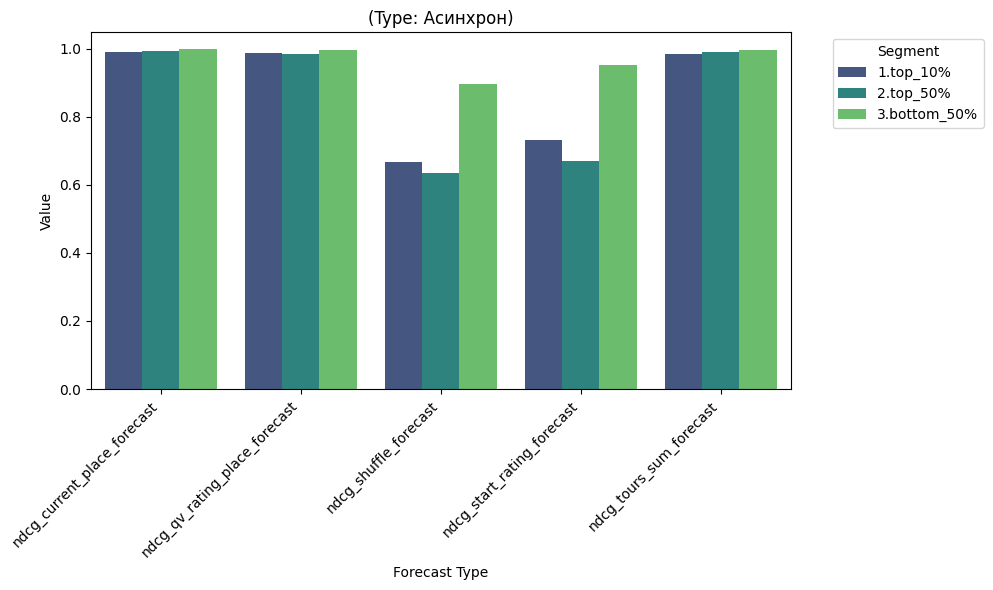

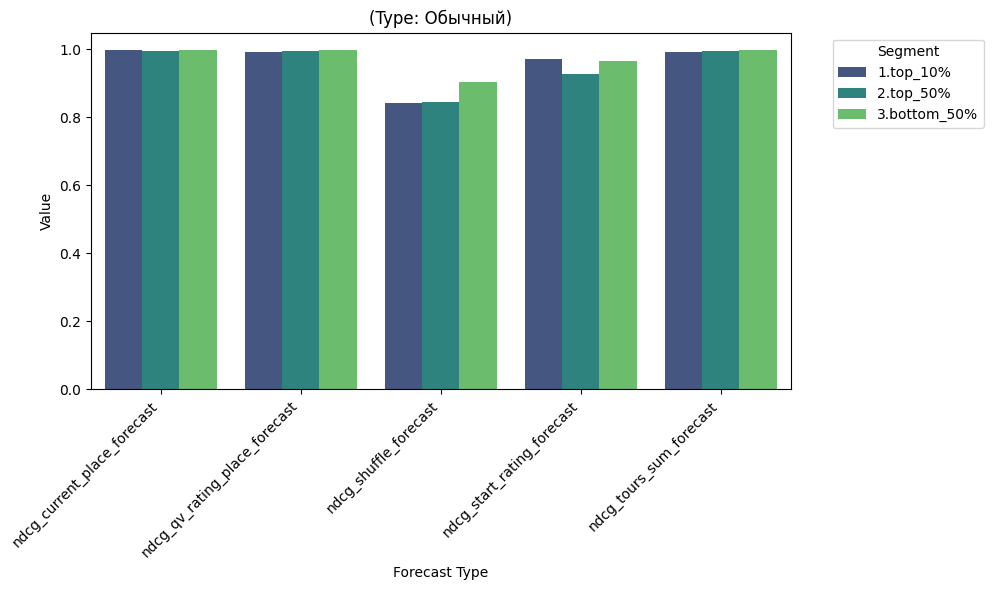

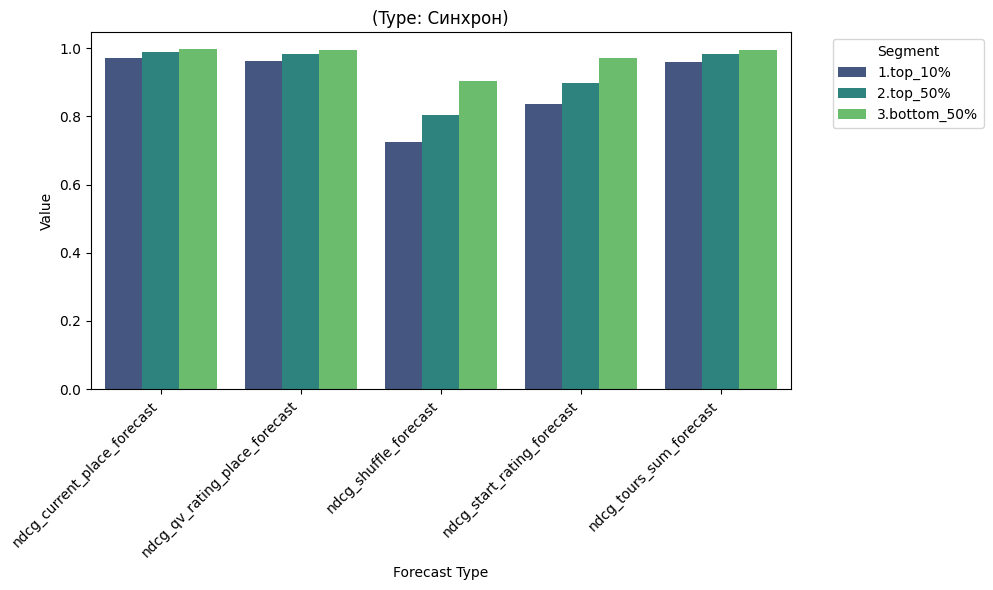

In [67]:
import matplotlib.pyplot as plt
import seaborn as sns
total_df_melted = total_df.melt(id_vars=['segment', 'type'], 
                                  value_vars=[
                                              'ndcg_current_place_forecast', 
                                              'ndcg_qv_rating_place_forecast', 
                                              'ndcg_shuffle_forecast',
                                              'ndcg_start_rating_forecast',
                                              'ndcg_tours_sum_forecast',
                                              ],
                                  var_name='forecast_type', 
                                  value_name='value')

tourn_types = total_df_melted['type'].unique()

for forecast_type in tourn_types:
    plt.figure(figsize=(10, 6))  # Задаем размер графика
    sns.barplot(data=total_df_melted[total_df_melted['type']==forecast_type], x='forecast_type', y='value', hue='segment', palette='viridis')
    plt.title(f'(Type: {forecast_type})')
    plt.xlabel('Forecast Type')
    plt.ylabel('Value')
    plt.xticks(rotation=45, ha='right')
    plt.legend(title='Segment', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

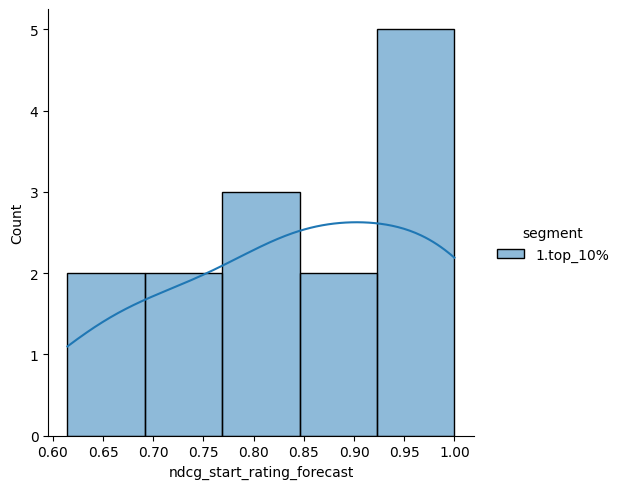

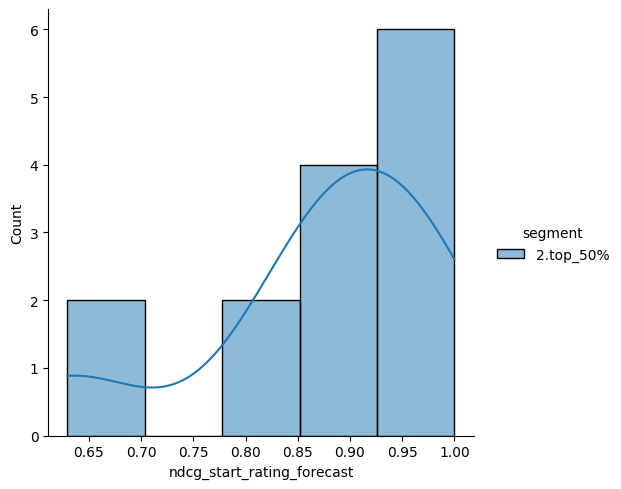

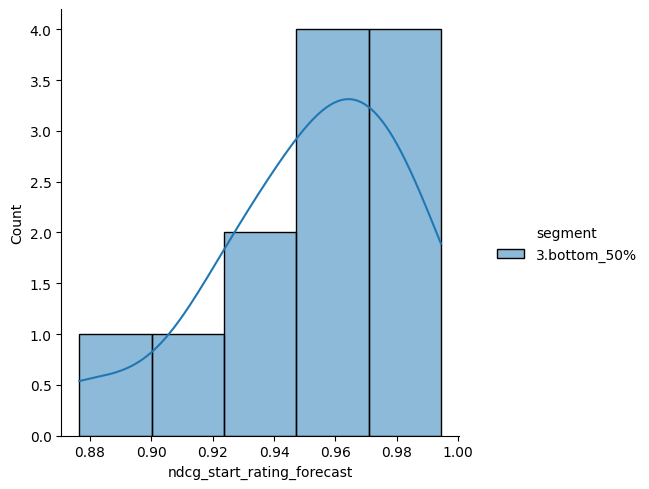

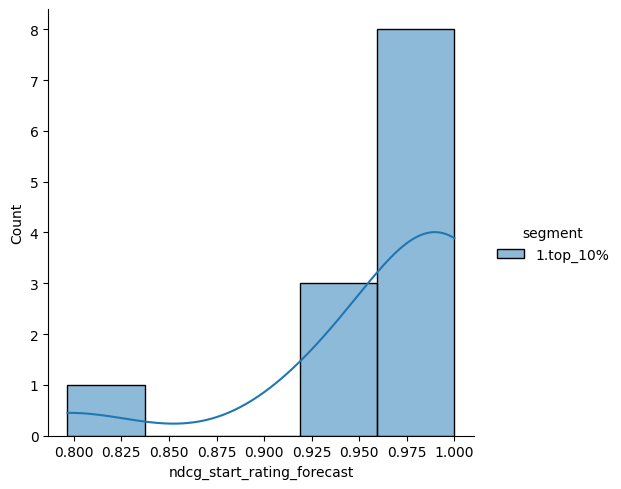

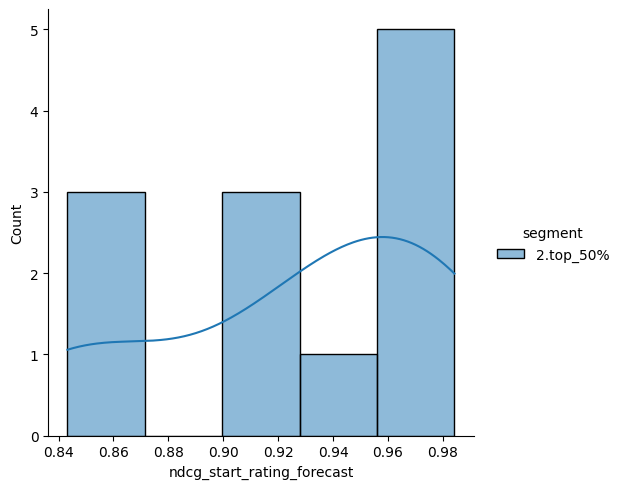

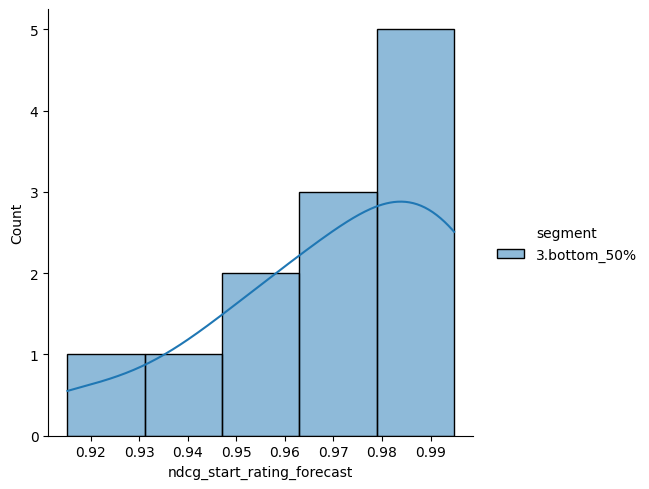

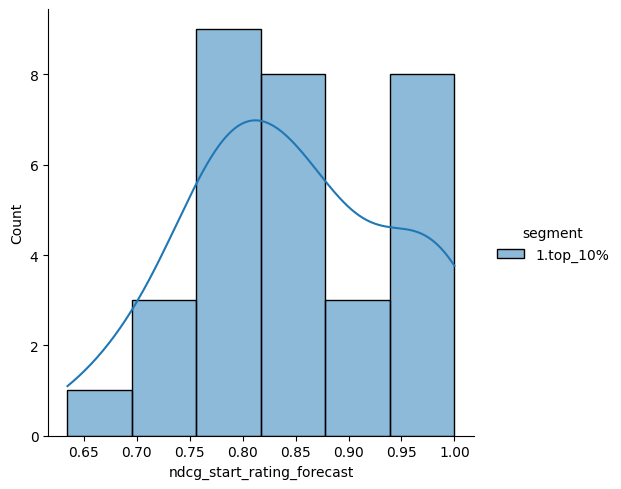

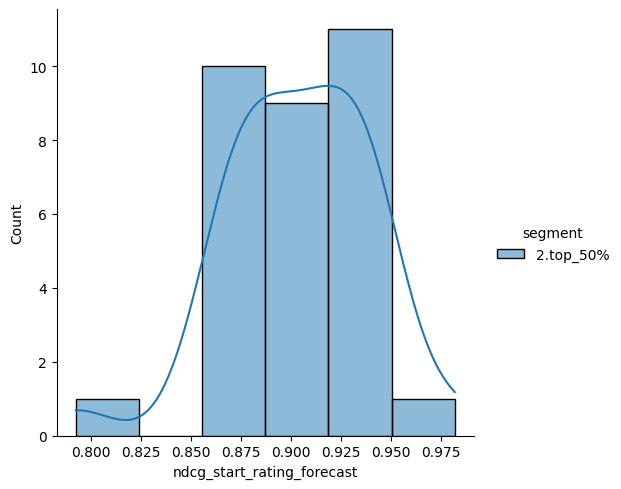

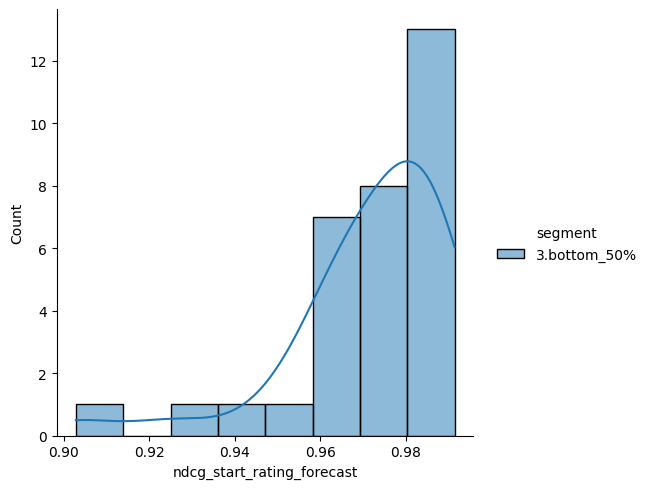

In [74]:
for type in tourn_types:
    for segment in forec_df['segment'].unique():
        sns.displot(
                        data=forec_df[
                            (forec_df['type']==type) &
                            (forec_df['segment']==segment)
                                    ], 
                        x="ndcg_start_rating_forecast", kde=True, hue='segment'
                    )

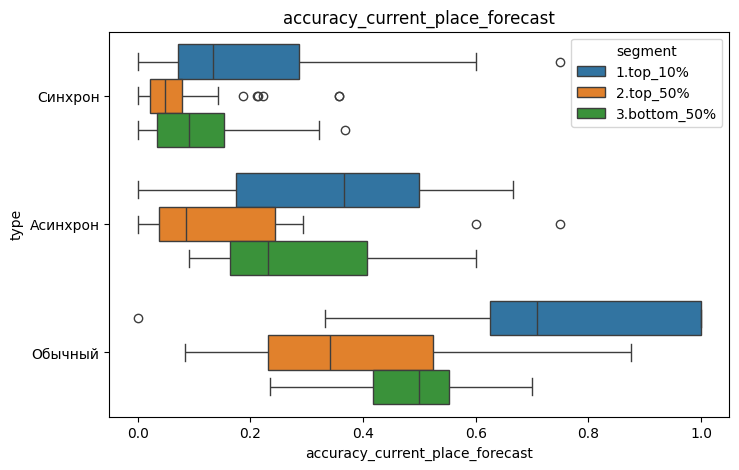

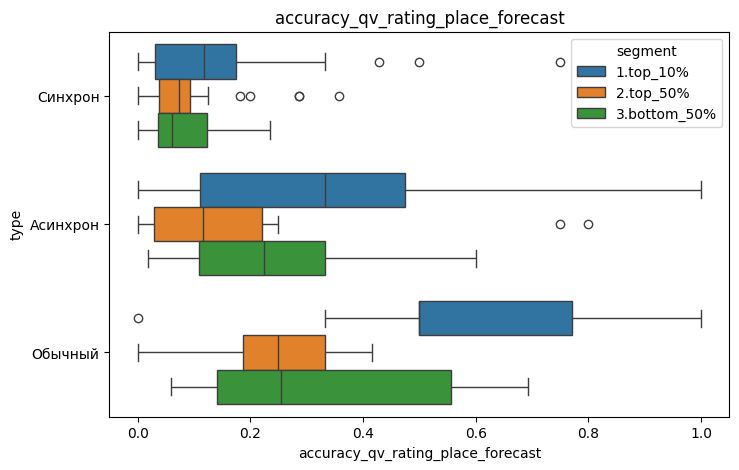

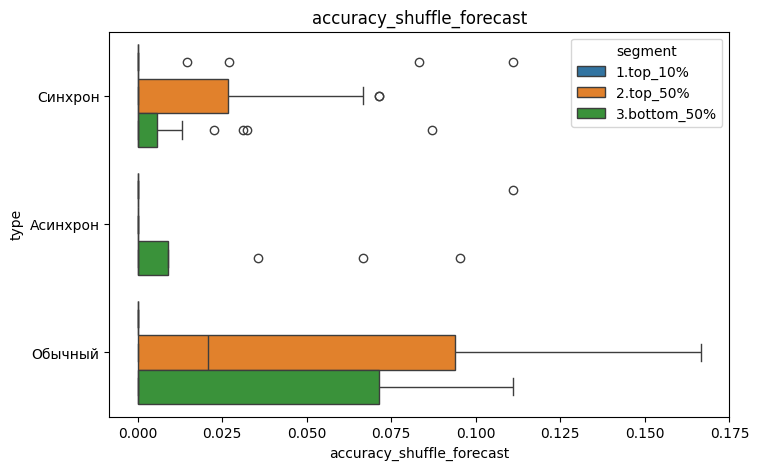

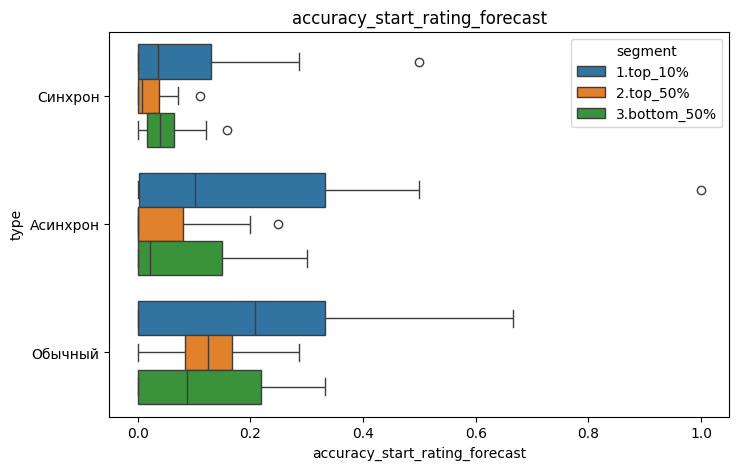

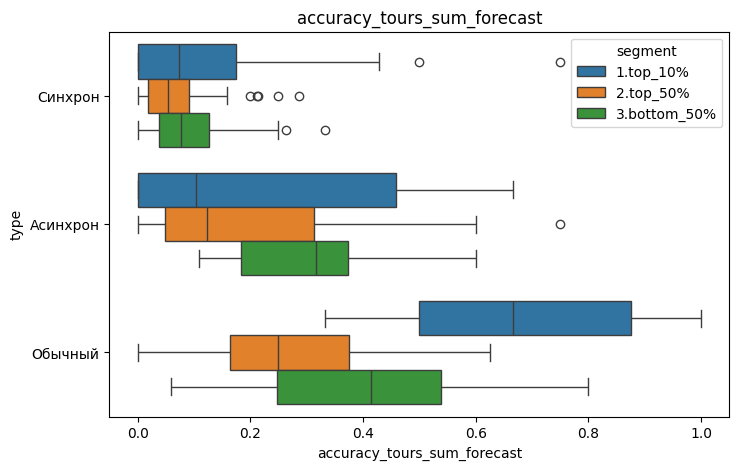

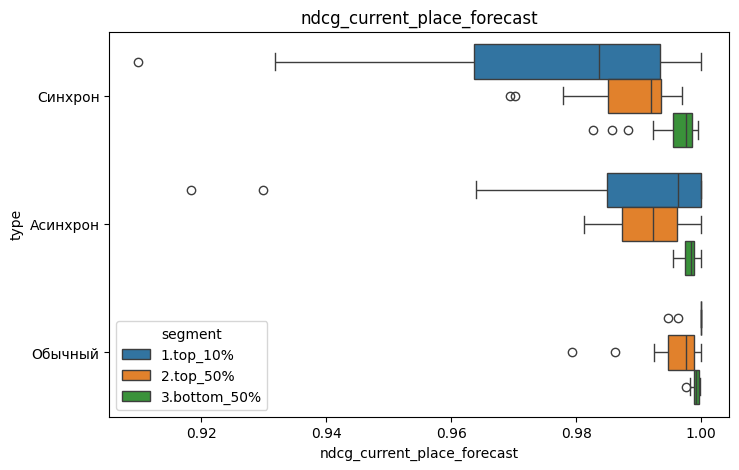

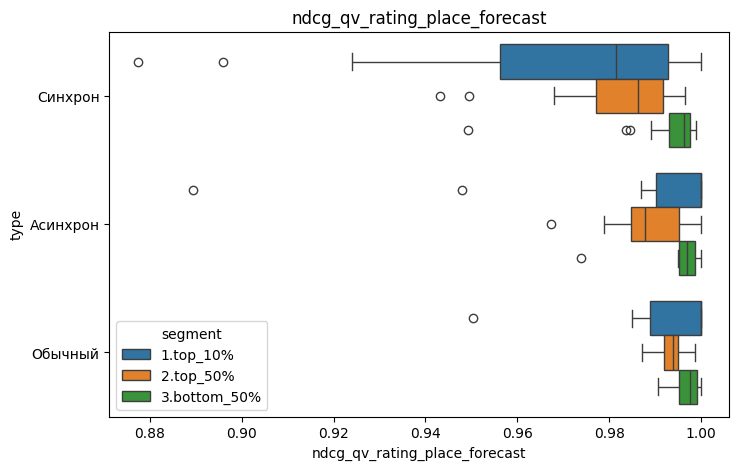

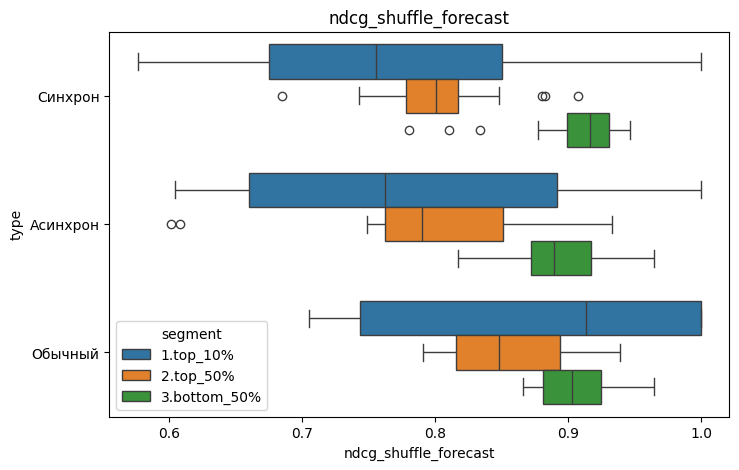

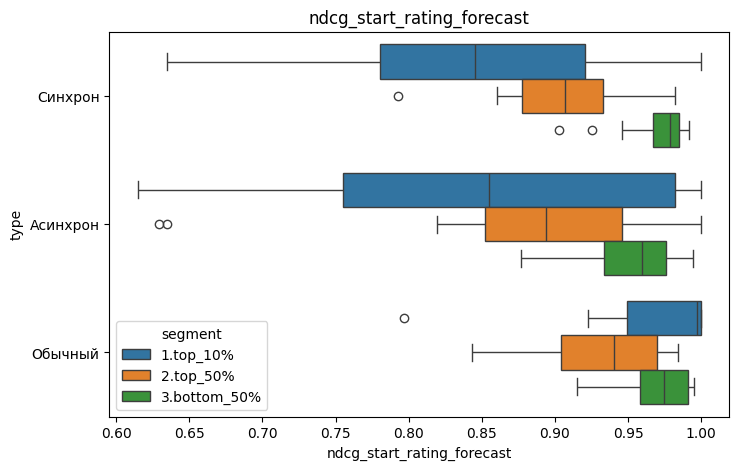

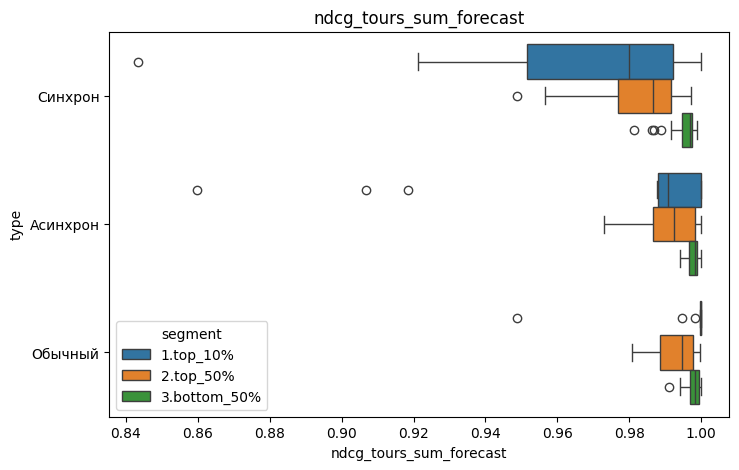

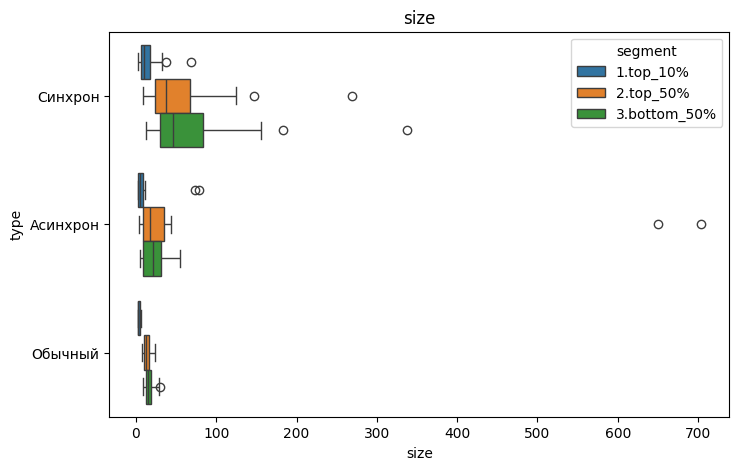

In [81]:
for metric in metric_cols:
    sns.boxplot(
                            data=forec_df, 
                            x=metric,
                            hue="segment",
                            y='type',
                        )
    plt.title(metric)
    plt.show()